# Logistic Regression
This code is implemented to answer question 8 & 9 in homework 5 of the Learning from Data course at Caltech: http://work.caltech.edu/homework/hw5.pdf

In this problem, we learn how to use logistic regression for classification.

# Problem statement
In this problem, you will create your own target function $f$ (probability in this case) and dataset $\mathcal{D}$ to see how logistic regression works. For simplicity, we will take $f$ to be a $0$/$1$ probability so $y$ is a deterministic function of x.

Take $d = 2$ so you can visualize the problem, and let $\mathcal{X} = [-1, 1]\times[-1, 1]$ with uniform probability of picking each $x \in \mathcal{X}$. Choose a line in the plane as the boundary between $f(x) = 1$ (where $y$ has to be $+1$) and $f(x) = 0$ (where $y$ has to be $-1$) by taking two random, uniformly distributed points from $\mathcal{X}$ and taking the line passing through them as the boundary between $y = \pm 1$. Pick $N = 100$ training points at random from $\mathcal{X}$, and evaluate the outputs $y_n$ for each of these points $\mathbf{x}_n$.

Run logistic regression with stochastic gradient descent to find the best parameters for our model, and estimate $E_{out}$ (the cross entropy error) by generating a sufficiently large, separate set of points to evaluate the error. Repeat the experiment for $100$ runs with different targets and take the average. Initialize the weight vector of logistic regression to all zeros in each run. Stop the algorithm when $\| \mathbf{w}^{(t-1)} - \mathbf{w}^{(t)} \| < 0.01 $, where $\mathbf{w}^{(t)}$ denotes the weight vector at the end of epoch $t$. An epoch is a full pass through $N$ data points (use a random permutation of $1, 2, ..., N$ to present the data points to the algorithm within each epoch, and use different permutations for different epochs). Use a learning rate of $0.01$.

In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

In [4]:
# Calculate sigmoid function.
def sigmoid(s):
    return math.e**s / (1 + math.e**s)

In [5]:
# class Point 2D
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def asVector(self):
        return np.array([self.x, self.y])
    
    @staticmethod
    def random():
        return Point(random.uniform(-1, 1), random.uniform(-1, 1))

In [6]:
# class Line in the 2D plane
class Line:
    def __init__(self, a, b, c):
        # ax + by + c = 0
        self.a = a
        self.b = b
        self.c = c
    
    # return the point on this line with horizontal coordinate x
    def getPointAtX(self, x):
        if self.b == 0:
            return Point(x, -1)
        return Point(x, (-self.a*x - self.c) / self.b)
    
    # evaluate whether a given point is on the upper or lower area of this line
    def evaluatePoint(self, point):
        return np.sign(self.a*point.x + self.b*point.y + self.c)
    
    # generate a random line equation (equivalent to generating a random target function in our example)
    @staticmethod
    def random():
        # generate two random points
        p1 = Point.random()
        p2 = Point.random()
        
        # compute the perpendicular vector of this line
        u = [-(p2.y - p1.y), p2.x - p1.x]
        return Line(u[0], u[1], -u[0]*p1.x - u[1]*p1.y)

In [123]:
class LogisticRegression:
    @staticmethod
    def train(X, Y, learning_rate=0.01):
        # Get the number of data points and the dimensionality of the input space.
        N, d = X.shape
        # Add the bias term to the vector of each data point.
        x = np.array([np.insert(X[i], 0, 1) for i in range(N)])
        
        # Initial weights.
        W = np.zeros(d + 1)
        
        # Weight in the previous epoch. This is to compare the squared difference between the weight vectors
        # of 2 consecutive epochs and determine whether to terminate the algorithm.
        prev_W = np.zeros(d + 1)
        
        n_iters = 0
        # Repeat until convergence.
        while True:
            n_iters += 1
            # Randomly generate a permutation of N numbers [0, 1, ..., N-1].
            # Each number is used as an index to pick a random data point from the dataset and put into our
            # stochastic gradient descent.
            P = np.random.permutation(N)
            
            for idx in P:
                # Compute the partial derivative of the error function with respect to the weight vector at
                # the current values of W.
                dE = -Y[idx] * x[idx] * sigmoid(-Y[idx] * np.dot(W, x[idx]))
                
                # Move down the hill.
                W -= learning_rate * dE
                
            # Compute the cross entropy error for the training dataset.
            # error = LogisticRegression.getError(W, x, Y)
            # print(error)

            # Compute the squared difference between the previous and the current weight vector.
            diff = np.dot(prev_W - W, prev_W - W) ** 0.5
            # print('diff = ', diff)

            # Terminate if difference is less than 0.01
            if diff < 0.01:
                break
            prev_W = np.copy(W)
        
        return [W, n_iters]
    
    def getError(W, x, Y):
        res = 0
        for i in range(x.shape[0]):
            res += math.log(1 / sigmoid(Y[i] * np.dot(W, x[i])))
        return res

In [124]:
# Perform experiment with N data points.
def experiment(N, plot=False):
    # N is the number of data points to generate.

    # Initialize a random line to separate the plane into 2 parts: one for blue points, one for red points.
    L = Line.random()

    # Initialize N random points.
    # X0 and Y0 store the X and Y coordinates of points with label 1.
    # X1 and Y1 store the X and Y coordinates of points with label -1.
    training_examples = [Point.random() for _ in range(N)]
    X0 = [training_examples[_].x for _ in range(N) if L.evaluatePoint(training_examples[_]) == 1]
    Y0 = [training_examples[_].y for _ in range(N) if L.evaluatePoint(training_examples[_]) == 1]
    X1 = [training_examples[_].x for _ in range(N) if L.evaluatePoint(training_examples[_]) == -1]
    Y1 = [training_examples[_].y for _ in range(N) if L.evaluatePoint(training_examples[_]) == -1]

    # Create data to put into logistic regression class for learning.
    X = np.array([training_examples[_].asVector() for _ in range(N)])
    Y = np.array([L.evaluatePoint(training_examples[_]) for _ in range(N)])

    # Find the best parameters.
    [W, n_iters] = LogisticRegression.train(X, Y)
    
    # Classify using our computed parameters.
    X2 = [training_examples[_].x for _ in range(N) if \
          sigmoid(np.dot(W, np.insert(training_examples[_].asVector(), 0, 1))) >= 0.5]
    Y2 = [training_examples[_].y for _ in range(N) if \
          sigmoid(np.dot(W, np.insert(training_examples[_].asVector(), 0, 1))) >= 0.5]
    X3 = [training_examples[_].x for _ in range(N) if \
          sigmoid(np.dot(W, np.insert(training_examples[_].asVector(), 0, 1))) < 0.5]
    Y3 = [training_examples[_].y for _ in range(N) if \
          sigmoid(np.dot(W, np.insert(training_examples[_].asVector(), 0, 1))) < 0.5]

    if plot:
        fig = plt.figure(figsize=(16, 5))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)

        ax1.set_xlim(-1, 1)
        ax1.set_ylim(-1, 1)
        ax2.set_xlim(-1, 1)
        ax2.set_ylim(-1, 1)

        ax1.scatter(X0, Y0, color="r")
        ax1.scatter(X1, Y1, color="b")
        ax1.plot((-1, 1), (L.getPointAtX(-1).y, L.getPointAtX(1).y), color="r")

        ax2.scatter(X2, Y2, color="r")
        ax2.scatter(X3, Y3, color="b")
        
    return [L, W, n_iters]

Figure on the left shows N data points with the decision boundary that separates them.
Figure on the right shows the color of those N data points that have been classified by our logistic regression model


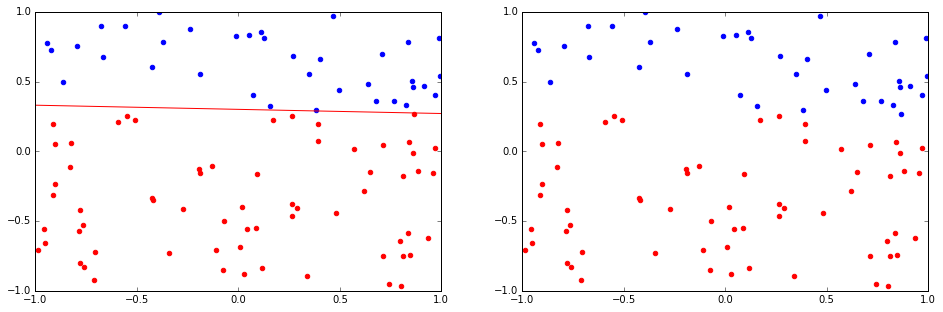

In [125]:
# Example of an experiment with 100 points.
[L, W, n_iters] = experiment(100, True)
print('Figure on the left shows N data points with the decision boundary that separates them.')
print('Figure on the right shows the color of those N data points that have been classified by our logistic regression model')

In [126]:
# Number of experiments.
N_experiments = 100

# Expected out-of-sample cross entropy error
E_out = 0

# Average number of iterations
avg_iters = 0
for _ in range(N_experiments):
    # Number of data points to estimate E_out
    N_train_examples = 100
    [L, W, n_iters] = experiment(N_train_examples)
    avg_iters += n_iters
    
    N_test_examples = 1000
    test_examples = [Point.random() for _ in range(N_test_examples)]
    X = np.array([np.insert(test_examples[_].asVector(), 0, 1) for _ in range(N_test_examples)])
    Y = np.array([L.evaluatePoint(test_examples[_]) for _ in range(N_test_examples)])
    E_out += LogisticRegression.getError(W, X, Y) / N_test_examples

E_out /= N_experiments
print('Expected E_out = ', E_out)

avg_iters /= N_experiments
print('Average number of iterations = ', avg_iters)

Expected E_out =  0.10349230951568499
Average number of iterations =  343.87
